# Real Data

## Paper plot of Real data

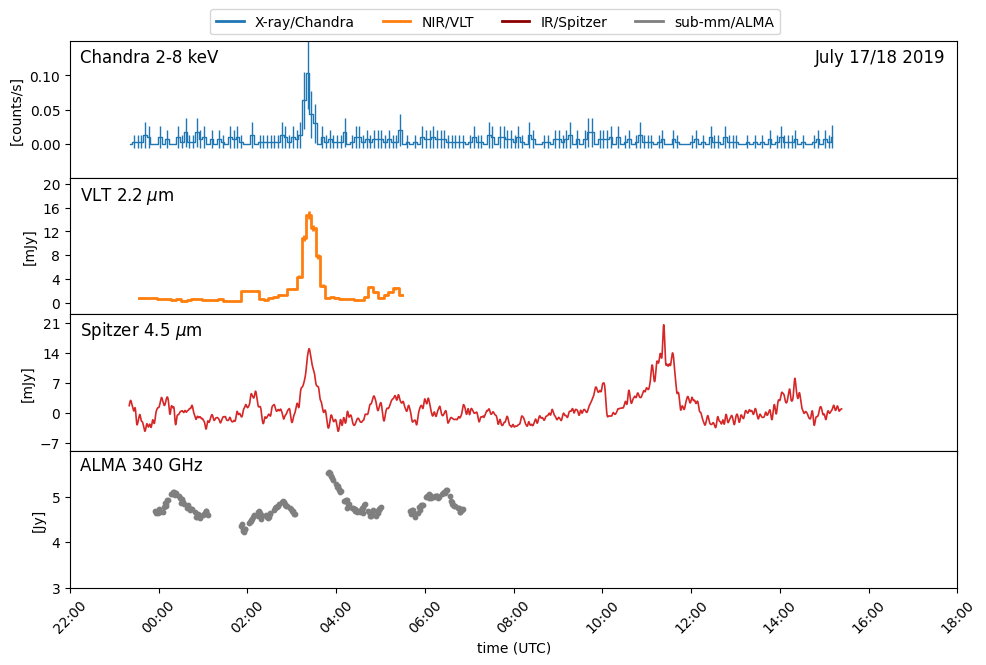

In [31]:
from astropy.time import Time
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
plt.style.use('default')

data_path = '../../Data/'

# Create a single figure with three subplots that share the same x-axis
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
flux2 = df2[:, 1]
error2 = df2[:, 2]
time2 = (Time(bmjd2, format='mjd', scale='tcb').utc).to_datetime()
axs[0].errorbar(time2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[0].set_ylim(-0.05, 0.15)
axs[0].set_yticks([0.0, 0.05, 0.10])
axs[0].set_ylabel('[counts/s]')

# Plot 2
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
flux3 = df3[:, 1]
error3 = df3[:, 2]
time3 = (Time(bmjd3, format='mjd', scale='tcb').utc).to_datetime()
axs[1].errorbar(time3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[1].set_ylim(-2, 21)
axs[1].set_yticks([0, 4, 8, 12, 16, 20])
axs[1].set_ylabel('[mJy]')

# Plot 3
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
time4 = (Time(bmjd4, format='mjd', scale='tcb').utc).to_datetime()
axs[2].plot(time4, flux_binned4, linewidth=1.2, color='tab:red')
axs[2].set_ylim(-9, 23)
axs[2].set_yticks([-7, 0, 7, 14, 21])
axs[2].set_ylabel('[mJy]')

# Plot 4
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
flux5 = df5[:, 3]
time5 = (Time(bmjd5, format='mjd', scale='tcb').utc).to_datetime()
axs[3].scatter(time5, flux5, s=10, color='tab:gray')
axs[3].set_ylim(3, 6)
axs[3].set_yticks([3.0, 4.0, 5.0])
axs[3].set_ylabel('[Jy]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
start_time = datetime.strptime('2019-07-17 22:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
end_time = datetime.strptime('2019-07-18 18:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
interval = timedelta(hours=2)
xticks = [start_time + i * interval for i in range(int((end_time - start_time) / interval) + 1)]
xtick_labels = [t.strftime('%H:%M') for t in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[3].set_xticks(xticks)
axs[3].set_xticklabels(xtick_labels, rotation=45)
axs[3].set_xlabel('time (UTC)')

# Manually set x-axis limits to start at "00:00"
xstart = datetime.strptime('2019-07-17 23:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
xend = datetime.strptime('2019-07-18 15:30:00.0', "%Y-%m-%d %H:%M:%S.%f")

legend_handles = [Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
                 Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
                 Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
                 Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),]

# Add date
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=12)
fig.text(0.085, 0.94, 'Chandra 2-8 keV', fontsize=12)
fig.text(0.085, 0.71, fr'VLT 2.2 $\mu$m', fontsize=12)
fig.text(0.085, 0.485, 'Spitzer 4.5 $\mu$m', fontsize=12)
fig.text(0.085, 0.26, 'ALMA 340 GHz', fontsize=12)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# for ax in axs:
#     ax.axvspan('2019-07-18 02:55:00.0', '2019-07-18 03:50:00.0', color='#222e69', alpha=0.2)

# Show the combined figure
plt.savefig('raw_data.pdf', bbox_inches='tight', format='pdf')
plt.show()

## Pre-process it and save  for model processing

### For Full Interpolation

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import copy
np.random.seed(0)

def prepare_and_save_real_data(data_path, save_file_path, keys=['X', 'NIR', 'IR', 'Sub-mm'], ir_mask_percentage=0.5):
    """
    Prepares, standardizes, masks IR data, and saves the real dataset in two formats,
    along with the standardization parameters.

    Args:
        data_path (str): Path to the directory containing the real data files.
        save_file_path (str): Path to save the processed data file (real_data.npz).
        keys (list): List of keys corresponding to each data file.
        ir_mask_percentage (float): Percentage of IR data to mask (0 to 1).
    """

    data_dict = {}
    timesteps = 0
    standardization_params = {}

    all_first_times = []
    all_last_times = []

    # Load data and convert time to minutes since start
    for key in keys:
        if key == 'X':
            file = data_path + '0718chan.dat'
            df = np.genfromtxt(file)
            bmjd = df[:, 0]
            flux = df[:, 1]
        elif key == 'NIR':
            file = data_path + '0718grav.dat'
            df = np.genfromtxt(file)
            bmjd = df[:, 0]
            flux = df[:, 1]
        elif key == 'IR':
            file = data_path + '0718sptz.dat'
            df = np.genfromtxt(file)
            bmjd = df[:, 0]
            flux = df[:, 2] * 1e3 #binned data
        elif key == 'Sub-mm':
            file = data_path + '0718alma.dat'
            df = np.genfromtxt(file, delimiter=' ')
            bmjd = df[:, 2]
            flux = df[:, 3]

        time_astropy = (Time(bmjd, format='mjd', scale='tcb').utc)
        all_first_times.append(time_astropy.min())
        all_last_times.append(time_astropy.max())

        # Keep track of original UTC times for each data point
        data_dict[key] = {'original_utc_time': time_astropy.to_datetime(), 'flux': flux}

    # Determine overall start time and total timesteps
    overall_start_time_astropy = Time(min(all_first_times).mjd, format='mjd', scale='utc')
    overall_start_datetime = overall_start_time_astropy.to_datetime()

    overall_end_time_astropy = Time(max(all_last_times).mjd, format='mjd', scale='utc')
    overall_end_datetime = overall_end_time_astropy.to_datetime()

    timesteps = int((overall_end_datetime - overall_start_datetime).total_seconds() / 60) + 1

    # Create the universal UTC time array
    universal_utc_time_array = np.array([overall_start_datetime + timedelta(minutes=i) for i in range(timesteps)])


    # Initialize the data array
    channels = len(keys)
    data = np.zeros((1, timesteps, channels * 2 + 1))  # +1 for time in tripletformer

    # Fill the data array
    for j, key in enumerate(keys):
        # Convert original UTC times to minutes relative to the overall start time
        minutes_since_overall_start = np.array([(t - overall_start_datetime).total_seconds() / 60
                                                for t in data_dict[key]['original_utc_time']]).astype(int)
        flux = data_dict[key]['flux']

        # Ensure minutes are within bounds (should be, given how timesteps is calculated)
        valid_indices = (minutes_since_overall_start >= 0) & (minutes_since_overall_start < timesteps)
        minutes_since_overall_start = minutes_since_overall_start[valid_indices]
        flux = flux[valid_indices]


        data[0, minutes_since_overall_start, j] = flux  # Fill flux values
        data[0, minutes_since_overall_start, channels + j] = 1  # Fill mask (1 for observed)

    # Mask IR data (your existing logic)
    ir_channel_index = keys.index('IR')
    ir_time_indices = np.where(data[0, :, channels + ir_channel_index] == 1)[0]
    num_ir_to_mask = int(len(ir_time_indices) * ir_mask_percentage)
    masked_ir_indices = np.random.choice(ir_time_indices, num_ir_to_mask, replace=False)
    data[0, masked_ir_indices, channels + ir_channel_index] = 0  # Set mask to 0

    # Time progression (for tripletformer)
    data[0, :, -1] = np.linspace(0, 1, timesteps)

    # Standardize the data and save parameters (your existing logic)
    for j in range(channels):
        channel_data = data[0, :, j]
        observed_data = channel_data[data[0, :, channels + j] == 1] #only standardize observed data.
        if len(observed_data) > 0:
            mean = np.mean(observed_data)
            std = np.std(observed_data)
            if std != 0: #avoid division by zero.
                data[0, :, j] = (data[0, :, j] - mean) / std
                standardization_params[keys[j]] = {'mean': mean, 'std': std}
            else:
                standardization_params[keys[j]] = {'mean': 0.0, 'std': 1.0} # Handle case with no variance
        else:
            standardization_params[keys[j]] = {'mean': 0.0, 'std': 1.0} # Handle case with no observed data

    # Save the data
    np.savez(save_file_path, real_data=data, universal_utc_time_array=universal_utc_time_array)

    # Save real_data_mogp.npz
    mogp_data = data[:, :, :-1]  # Remove the last channel (time)
    mogp_save_path = save_file_path.replace('.npz', '_mogp.npz')
    np.savez(mogp_save_path, real_data=mogp_data, universal_utc_time_array=universal_utc_time_array)


    # Save standardization parameters to a separate file
    params_save_path = save_file_path.replace('.npz', '_standardization.npz')
    np.savez(params_save_path, **standardization_params, allow_pickle=True)

    return data, universal_utc_time_array # Also return the time array for immediate use

# Example usage (assuming 'data_path' and 'save_file_path' are defined):
data_path = '../../Data/'
save_file_path = 'real_data.npz'
real_data = prepare_and_save_real_data(data_path, save_file_path)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import copy
np.random.seed(0)

def prepare_and_save_real_data(data_path, save_file_path, keys=['X', 'NIR', 'IR', 'Sub-mm'], ir_mask_percentage=0.5):
    """
    Prepares, standardizes, masks IR data, and saves the real dataset in two formats,
    along with the standardization parameters.

    Args:
        data_path (str): Path to the directory containing the real data files.
        save_file_path (str): Path to save the processed data file (real_data.npz).
        keys (list): List of keys corresponding to each data file.
        ir_mask_percentage (float): Percentage of IR data to mask (0 to 1).
    """

    data_dict = {}
    timesteps = 0
    standardization_params = {}

    # Load data and convert time to minutes since start
    for key in keys:
        if key == 'X':
            file = data_path + '0718chan.dat'
            df = np.genfromtxt(file)
            bmjd = df[:, 0]
            flux = df[:, 1]
        elif key == 'NIR':
            file = data_path + '0718grav.dat'
            df = np.genfromtxt(file)
            bmjd = df[:, 0]
            flux = df[:, 1]
        elif key == 'IR':
            file = data_path + '0718sptz.dat'
            df = np.genfromtxt(file)
            bmjd = df[:, 0]
            flux = df[:, 2] * 1e3 #binned data
        elif key == 'Sub-mm':
            file = data_path + '0718alma.dat'
            df = np.genfromtxt(file, delimiter=' ')
            bmjd = df[:, 2]
            flux = df[:, 3]

        time = (Time(bmjd, format='mjd', scale='tcb').utc).to_datetime()
        start_time = min(time)
        minutes_since_start = np.array([(t - start_time).total_seconds() / 60 for t in time])

        data_dict[key] = {'time': minutes_since_start, 'flux': flux}
        timesteps = max(timesteps, int(max(minutes_since_start)) + 1) #add one to account for zero indexing

    # Initialize the data array
    channels = len(keys)
    data = np.zeros((1, timesteps, channels * 2 + 1))  # +1 for time in tripletformer

    # Fill the data array
    for j, key in enumerate(keys):
        minutes = data_dict[key]['time'].astype(int)
        flux = data_dict[key]['flux']

        data[0, minutes, j] = flux  # Fill flux values
        data[0, minutes, channels + j] = 1  # Fill mask (1 for observed)

    # Mask IR data
    ir_channel_index = keys.index('IR')
    ir_time_indices = np.where(data[0, :, channels + ir_channel_index] == 1)[0]
    num_ir_to_mask = int(len(ir_time_indices) * ir_mask_percentage)
    masked_ir_indices = np.random.choice(ir_time_indices, num_ir_to_mask, replace=False)
    data[0, masked_ir_indices, channels + ir_channel_index] = 0  # Set mask to 0

    # Time progression (for tripletformer)
    data[0, :, -1] = np.linspace(0, 1, timesteps)

    # Standardize the data and save parameters
    for j in range(channels):
        channel_data = data[0, :, j]
        observed_data = channel_data[data[0, :, channels + j] == 1] #only standardize observed data.
        if len(observed_data) > 0:
            mean = np.mean(observed_data)
            std = np.std(observed_data)
            if std != 0: #avoid division by zero.
                data[0, :, j] = (data[0, :, j] - mean) / std
                standardization_params[keys[j]] = {'mean': mean, 'std': std}
            else:
                standardization_params[keys[j]] = {'mean': 0.0, 'std': 1.0} # Handle case with no variance
        else:
            standardization_params[keys[j]] = {'mean': 0.0, 'std': 1.0} # Handle case with no observed data

    # Save the data in the same format as simulated data
    np.savez(save_file_path, real_data=data)

    # Save real_data_mogp.npz
    mogp_data = data[:, :, :-1]  # Remove the last channel (time)
    mogp_save_path = save_file_path.replace('.npz', '_mogp.npz')
    np.savez(mogp_save_path, real_data=mogp_data)

    # Save standardization parameters to a separate file
    params_save_path = save_file_path.replace('.npz', '_standardization.npz')
    np.savez(params_save_path, **standardization_params, allow_pickle=True)

    return data

# Example usage (assuming 'data_path' and 'save_file_path' are defined):
data_path = '../../Data/'
save_file_path = 'real_data.npz'
real_data = prepare_and_save_real_data(data_path, save_file_path)

## Load pre-processed data and plot it for verification

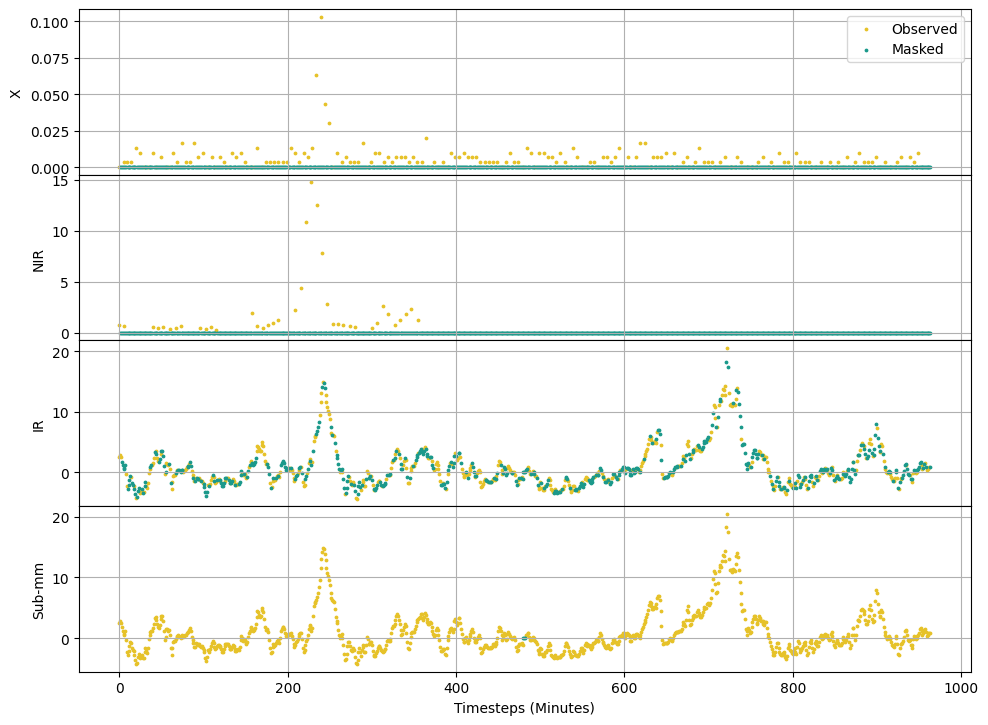

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def plot_real_data(real_data, standardization_values, keys=['X', 'NIR', 'IR', 'Sub-mm'], save_path='real_data_plot_rescaled.png'):
    """
    Plots the real data prepared for the model, rescaled to its original range.

    Args:
        real_data (numpy.ndarray): The real data formatted as a numpy array (standardized).
        standardization_values (numpy.lib.npyio.NpzFile): Loaded standardization parameters.
        keys (list): List of keys corresponding to each data channel.
        save_path (str): Path to save the plot.
    """

    timesteps = real_data.shape[1]
    channels = len(keys)

    fig, axes = plt.subplots(channels, 1, figsize=(10, 2 * channels), sharex=True, gridspec_kw={'hspace': 0})
    time = np.arange(0, timesteps)

    if channels == 1:
        axes = [axes]

    for j, key in enumerate(keys):
        ydata_standardized = real_data[0, :, j]
        mask = real_data[0, :, channels + j]

        params_array = standardization_values[key]
        params = params_array.item()  # Get the pickled dictionary
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)

        ydata_rescaled = ydata_standardized * std + mean

        axes[j].scatter(time[mask == 1], ydata_rescaled[mask == 1], s=3, color='#E6C229', label='Observed')
        axes[j].scatter(time[mask == 0], ydata_rescaled[mask == 0], s=3, color='#1B998B', label='Masked')

        axes[j].set_ylabel(key)
        axes[j].grid(True)
        # You might still need to adjust ylim based on the original data ranges
        # axes[j].set_ylim(-3.5, 7.5) # Example, adjust as needed

        if j == 0:
            axes[j].legend(loc="upper right")

    axes[-1].set_xlabel("Timesteps (Minutes)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.show()

# Example usage:
if __name__ == '__main__':
    real_data_loaded = np.load('real_data.npz')['real_data']
    standardization_values = np.load('real_data_standardization.npz', allow_pickle=True)
    plot_real_data(real_data_loaded, standardization_values)

## Plot interpolation of real data

### Full Data

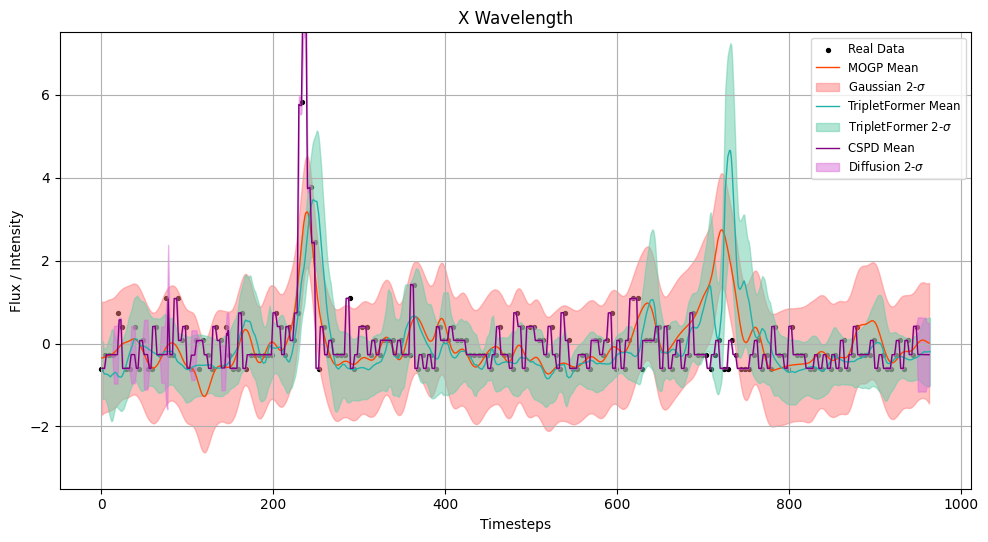

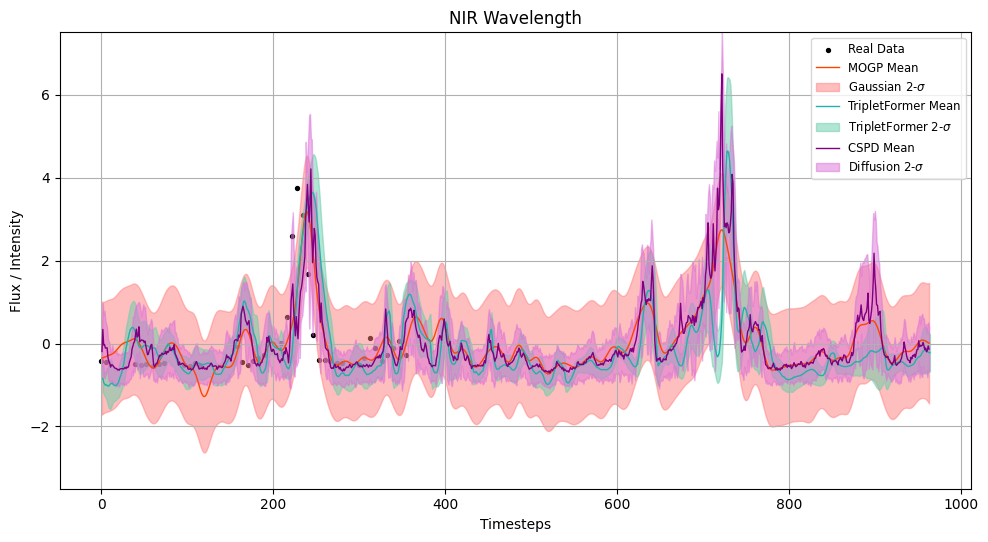

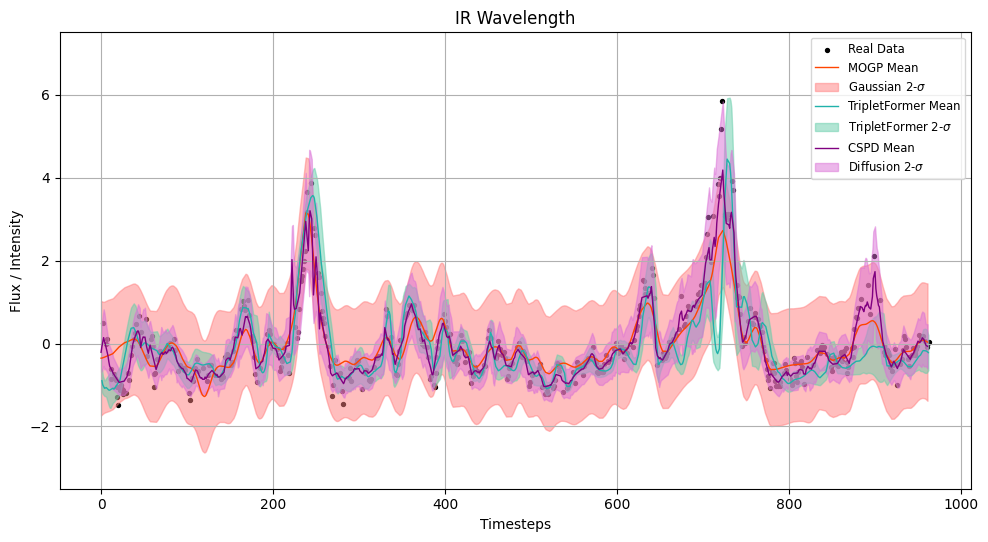

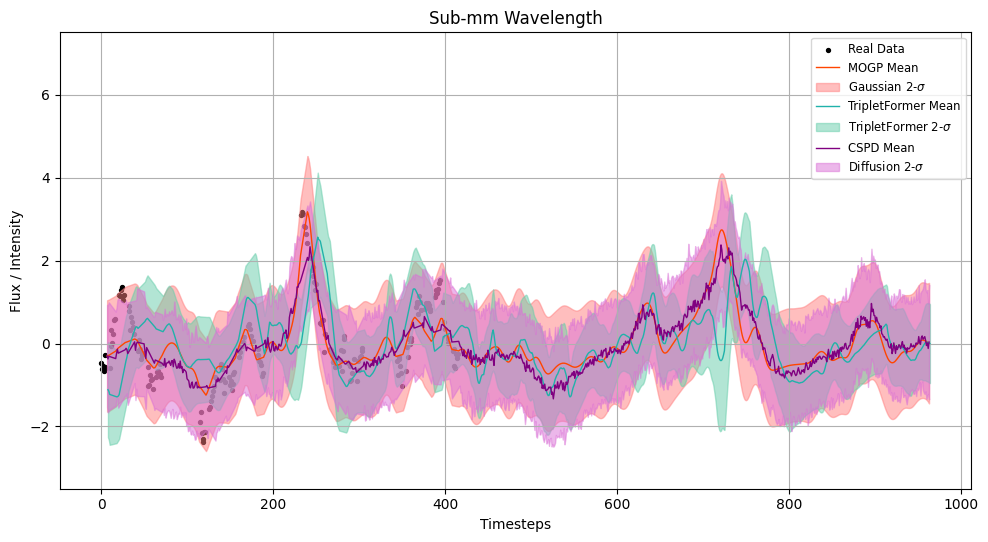

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_from_saved_data(keys=["X", 'NIR', "IR", "Sub-mm"], gaussian_file='../GPyTorch/real_results.npz', tripletformer_file='../Tripletformer/real_results.npz', diffusion_file='../Diffusion/real_results.npz'):
    """
    Plots the results from Gaussian, TripletFormer, and Diffusion models.

    Args:
        keys (list): List of keys to extract and plot data for.
        gaussian_file (str): Path to the Gaussian model results file.
        tripletformer_file (str): Path to the TripletFormer model results file.
        diffusion_file (str): Path to the Diffusion model results file.
    """

    # Load data from the Gaussian model
    gaussian_data = np.load(gaussian_file, allow_pickle=True)

    # Load data from the TripletFormer model
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)

    # Load data from the Diffusion model
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    for key in keys:
        # Gaussian model data
        gauss_train_x = gaussian_data[f"{key}_train_x"]
        gauss_train_y = gaussian_data[f"{key}_train_y"]
        gauss_test_x = gaussian_data[f"{key}_test_x"]
        gauss_test_y = gaussian_data[f"{key}_test_y"]
        gauss_pred_means = gaussian_data[f"{key}_predicted_means"]
        gauss_lower = gaussian_data[f"{key}_lower_bound"]
        gauss_upper = gaussian_data[f"{key}_upper_bound"]

        # TripletFormer model data
        triplet_train_x = tripletformer_data[f"{key}_train_x"]
        triplet_train_y = tripletformer_data[f"{key}_train_y"]
        triplet_test_x = tripletformer_data[f"{key}_test_x"]
        triplet_test_y = tripletformer_data[f"{key}_test_y"]
        triplet_pred_means = tripletformer_data[f"{key}_predicted_means"]
        triplet_lower = tripletformer_data[f"{key}_lower_bound"]
        triplet_upper = tripletformer_data[f"{key}_upper_bound"]

        # Diffusion model data
        diffusion_train_x = diffusion_data[f"{key}_train_x"]
        diffusion_train_y = diffusion_data[f"{key}_train_y"]
        diffusion_test_x = diffusion_data[f"{key}_test_x"]
        diffusion_test_y = diffusion_data[f"{key}_test_y"]
        diffusion_pred_means = diffusion_data[f"{key}_predicted_means"]
        diffusion_lower = diffusion_data[f"{key}_lower_bound"]
        diffusion_upper = diffusion_data[f"{key}_upper_bound"]

        # Create a new figure for each wavelength
        plt.figure(figsize=(10, 6))

        # Plot observed (training and testing) data once
        plt.scatter(gauss_train_x, gauss_train_y, s=8, color='black', label='Real Data', alpha=1)

        # Plot Gaussian model results
        plt.plot(gauss_test_x, gauss_pred_means, color='#FF4500', label='MOGP Mean', linewidth=1)
        plt.fill_between(gauss_test_x, gauss_lower, gauss_upper, alpha=0.5, color='#FF7F7F', label=r'Gaussian 2-$\sigma$')

        # Plot TripletFormer model results
        plt.plot(triplet_test_x, triplet_pred_means, color='#20B2AA', label='TripletFormer Mean', linewidth=1)
        plt.fill_between(triplet_test_x, triplet_lower, triplet_upper, alpha=0.5, color='#66CDAA', label=r'TripletFormer 2-$\sigma$')

        # Plot Diffusion model results
        plt.plot(diffusion_test_x, diffusion_pred_means, color='#800080', label='CSPD Mean', linewidth=1)
        plt.fill_between(diffusion_test_x, diffusion_lower, diffusion_upper, alpha=0.5, color='#DA70D6', label=r'Diffusion 2-$\sigma$')

        # Set labels and title for each subplot
        plt.title(f"{key} Wavelength")
        plt.xlabel("Timesteps")
        plt.ylabel("Flux / Intensity")
        plt.ylim(-3.5, 7.5)
        plt.grid(True)

        # if key == 'X':
        plt.legend(loc="upper right", fontsize='small')


        # Show each plot individually
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage:
plot_from_saved_data()

/tmp/ipykernel_13033/2595003951.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


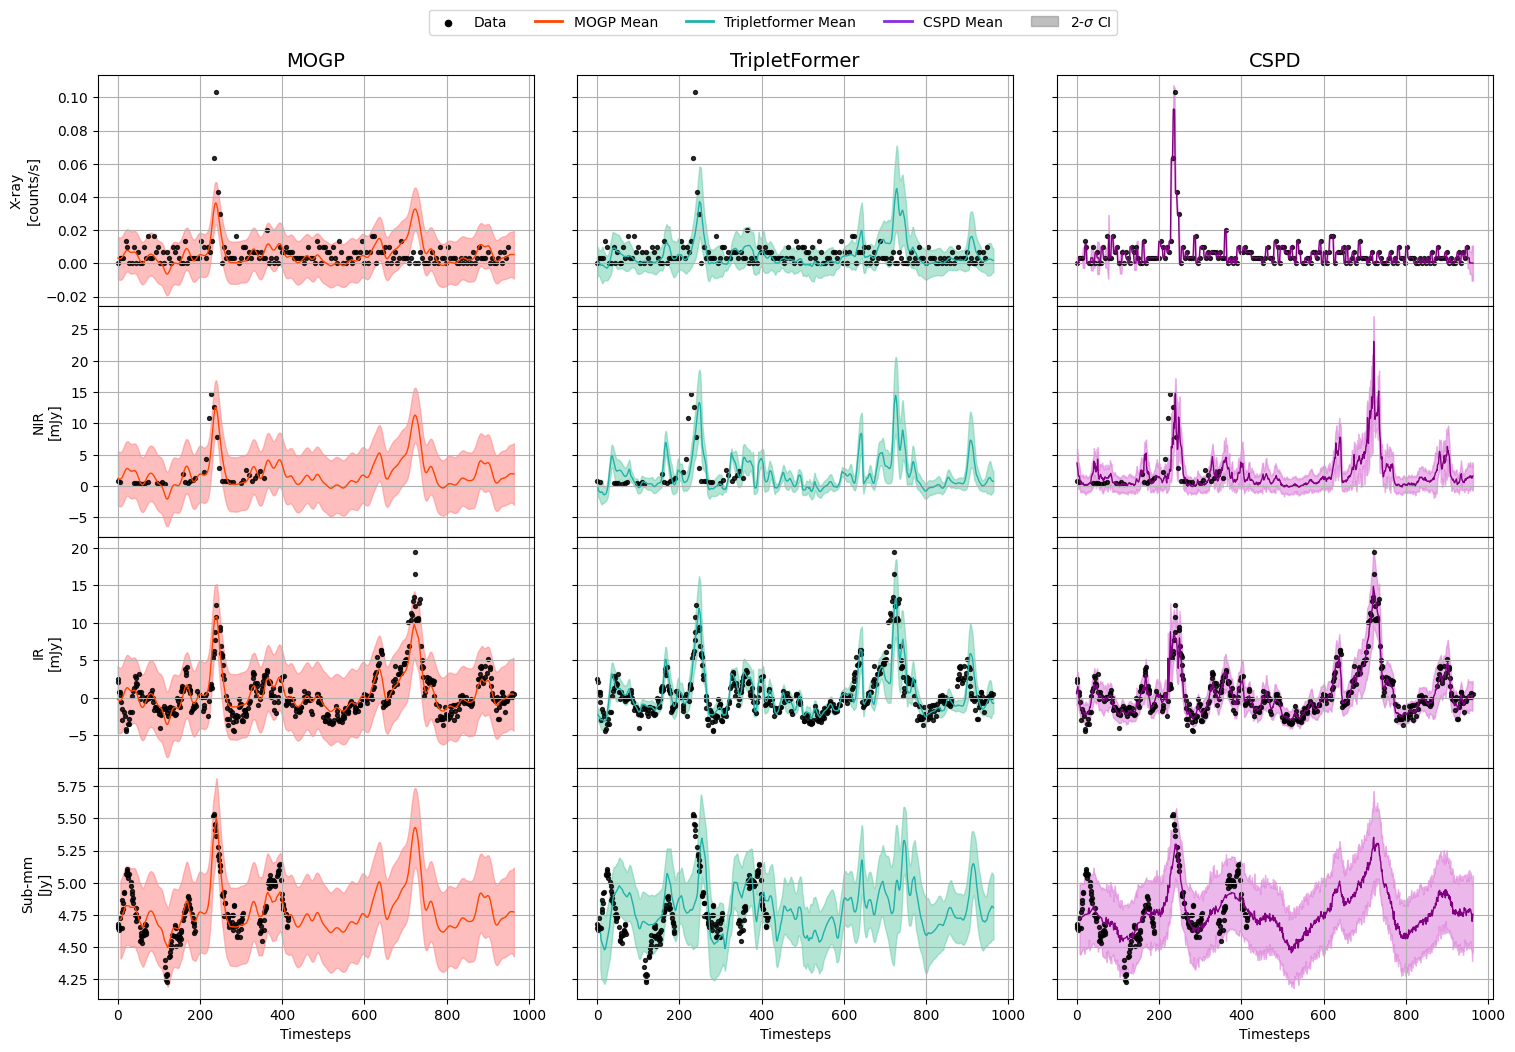

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_in_one(keys=["X", 'NIR', "IR", "Sub-mm"],
                    gaussian_file='../GPyTorch/real_results.npz',
                    tripletformer_file='../Tripletformer/real_results.npz',
                    diffusion_file='../Diffusion/real_results.npz',
                    standardization_file='real_data_standardization.npz',
                    y_labels=None):
    """
    Plots the results from Gaussian, TripletFormer, and Diffusion models
    in a single 4x3 figure (rows = wavelengths, columns = models),
    with all values rescaled using saved standardization parameters.
    """
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    standardization_raw = np.load(standardization_file, allow_pickle=True)
    standardization = {
        key: standardization_raw[key].item() if isinstance(standardization_raw[key], np.ndarray) else standardization_raw[key]
        for key in standardization_raw.files
    }


    fig, axes = plt.subplots(
        nrows=len(keys), ncols=3, figsize=(18, 12),
        sharex='col', sharey='row',
        gridspec_kw={'hspace': 0, 'wspace': 0.1}
    )

    model_names = ['MOGP', 'TripletFormer', 'CSPD']
    colors = [
        ('#FF4500', '#FF7F7F'),
        ('#20B2AA', '#66CDAA'),
        ('#800080', '#DA70D6')
    ]

    for row_idx, key in enumerate(keys):
        mean = standardization[key]['mean']
        std = standardization[key]['std']

        all_train_x = [
            gaussian_data[f"{key}_train_x"],
            tripletformer_data[f"{key}_train_x"],
            diffusion_data[f"{key}_train_x"]
        ]
        all_train_y = [
            gaussian_data[f"{key}_train_y"],
            tripletformer_data[f"{key}_train_y"],
            diffusion_data[f"{key}_train_y"]
        ]
        all_test_x = [
            gaussian_data[f"{key}_test_x"],
            tripletformer_data[f"{key}_test_x"],
            diffusion_data[f"{key}_test_x"]
        ]
        all_pred_means = [
            gaussian_data[f"{key}_predicted_means"],
            tripletformer_data[f"{key}_predicted_means"],
            diffusion_data[f"{key}_predicted_means"]
        ]
        all_lowers = [
            gaussian_data[f"{key}_lower_bound"],
            tripletformer_data[f"{key}_lower_bound"],
            diffusion_data[f"{key}_lower_bound"]
        ]
        all_uppers = [
            gaussian_data[f"{key}_upper_bound"],
            tripletformer_data[f"{key}_upper_bound"],
            diffusion_data[f"{key}_upper_bound"]
        ]

        for col_idx in range(3):
            ax = axes[row_idx, col_idx]

            # Rescale
            train_y_rescaled = all_train_y[0] * std + mean
            pred_means_rescaled = all_pred_means[col_idx] * std + mean
            lower_rescaled = all_lowers[col_idx] * std + mean
            upper_rescaled = all_uppers[col_idx] * std + mean

            # Plot
            ax.plot(all_test_x[col_idx], pred_means_rescaled, color=colors[col_idx][0], linewidth=1)
            ax.fill_between(all_test_x[col_idx], lower_rescaled, upper_rescaled,
                            alpha=0.5, color=colors[col_idx][1])
            ax.scatter(all_train_x[0], train_y_rescaled, s=8, color='black', alpha=0.8)
            ax.grid(True)

            if row_idx == len(keys) - 1:
                ax.set_xlabel("Timesteps")

            if col_idx == 0:
                if y_labels is None:
                    ax.set_ylabel(f"{key}\nFlux / Intensity")
                else:
                    ax.set_ylabel(y_labels[row_idx])

            if row_idx == 0:
                ax.set_title(model_names[col_idx], fontsize=14)

    legend_handles = [ax.scatter([], [], s=20, color='Black', label='Data', alpha=1),
                 Line2D([0], [0], color='#FF4500', label='MOGP Mean', linewidth=2),
                 Line2D([0], [0], color='#20B2AA', label='Tripletformer Mean', linewidth=2),
                 Line2D([0], [0], color='#8A2BE2', label='CSPD Mean', linewidth=2),
                 ax.fill_between([], [], [], alpha=0.5, color='grey', label=r'2-$\sigma$ CI')]
    
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('real_data_interpolation.pdf', format='pdf')
    plt.show()

# Example usage:
plot_all_in_one(y_labels=['X-ray\n[counts/s]', 'NIR\n[mJy]', 'IR\n[mJy]', 'Sub-mm\n[Jy]'])


/tmp/ipykernel_41729/3726233129.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.93])


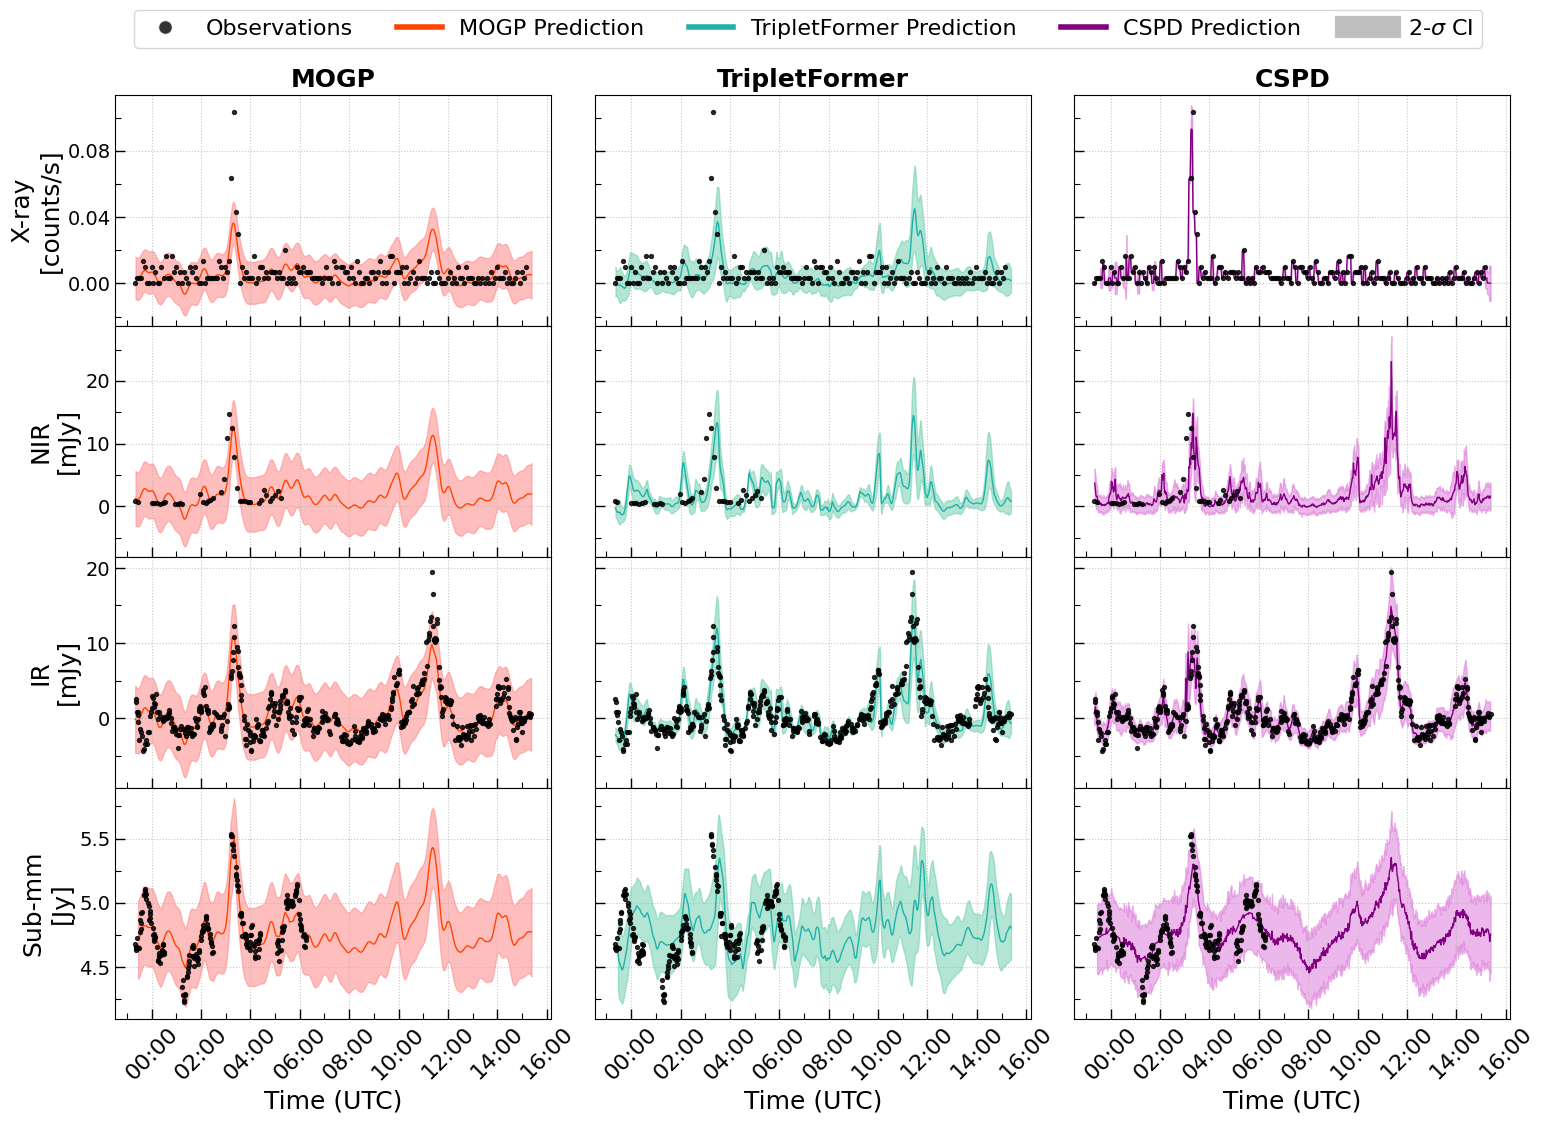

In [39]:
from matplotlib.dates import HourLocator, DateFormatter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
from matplotlib.ticker import MultipleLocator # Import MultipleLocator for Y-axis

def plot_all_in_one(keys=["X", 'NIR', "IR", "Sub-mm"],
                    gaussian_file='../GPyTorch/real_results.npz',
                    tripletformer_file='../Tripletformer/real_results.npz',
                    diffusion_file='../Diffusion/real_results.npz',
                    real_data_file='real_data.npz',
                    standardization_file='real_data_standardization.npz',
                    y_labels=None):
    """
    Plots the results from Gaussian, TripletFormer, and Diffusion models
    in a single 4x3 figure (rows = wavelengths, columns = models),
    with all values rescaled using saved standardization parameters and
    plotted against a universal UTC time axis.
    """
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    real_data_loaded = np.load(real_data_file, allow_pickle=True)
    universal_utc_time_array = real_data_loaded['universal_utc_time_array']

    standardization_raw = np.load(standardization_file, allow_pickle=True)
    standardization = {
        key: standardization_raw[key].item() if isinstance(standardization_raw[key], np.ndarray) else standardization_raw[key]
        for key in standardization_raw.files
    }

    fig, axes = plt.subplots(
        nrows=len(keys), ncols=3, figsize=(18, 12),
        sharex='col', sharey='row', # X-axis shared per column, Y-axis shared per row
        gridspec_kw={'hspace': 0, 'wspace': 0.1}
    )

    # Ensure axes is always a 2D array, even for a single row
    if len(keys) == 1:
        axes = np.array([axes])

    model_names = ['MOGP', 'TripletFormer', 'CSPD']
    colors = [
        ('#FF4500', '#FF7F7F'), # Orange for MOGP
        ('#20B2AA', '#66CDAA'), # Light Sea Green for TripletFormer
        ('#800080', '#DA70D6')  # Purple for CSPD
    ]

    max_valid_utc_index = len(universal_utc_time_array) - 1

    # --- X-axis Specifics: Formatter for Labels, Locator for Minor Ticks ---
    major_formatter = DateFormatter('%H:%M') # Format to show only Hour and Minute
    minor_locator = HourLocator(interval=1) # Minor ticks every 1 hour

    # Set custom x-axis limits (from your previous code)
    xlim_start = datetime.strptime('2019-07-16 23:15:00.0', "%Y-%m-%d %H:%M:%S.%f")
    xlim_end   = datetime.strptime('2019-07-18 00:45:00.0', "%Y-%m-%d %H:%M:%S.%f")

    # --- Y-axis Tick Intervals per Wavelength ---
    y_tick_intervals = {
        "X": {"major": 0.04, "minor": 0.02},
        "NIR": {"major": 10, "minor": 5},
        "IR": {"major": 10, "minor": 5},
        "Sub-mm": {"major": 0.50, "minor": 0.25},
    }

    # Define Y-axis limits per wavelength (if they differ from -3.5 to 8.0)
    # If not specified, the default -3.5 to 8.0 will be used, but ticks will be denser.
    # For now, keeping the -3.5 to 8.0 as per your previous code.
    y_limits = {
        "X": (-0.1, 0.2), # Example: adjust these if your data range is different
        "NIR": (-30, 80),
        "IR": (-30, 80),
        "Sub-mm": (-1.0, 3.0),
    }


    for row_idx, key in enumerate(keys):
        mean = standardization[key]['mean']
        std = standardization[key]['std']

        train_x_indices = gaussian_data[f"{key}_train_x"].astype(int)
        clipped_train_x_indices = np.clip(train_x_indices, 0, max_valid_utc_index)
        train_y_rescaled = gaussian_data[f"{key}_train_y"] * std + mean
        train_utc_times = universal_utc_time_array[clipped_train_x_indices]

        test_x_indices_mogp = gaussian_data[f"{key}_test_x"].astype(int)
        test_x_indices_triplet = tripletformer_data[f"{key}_test_x"].astype(int)
        test_x_indices_diffusion = diffusion_data[f"{key}_test_x"].astype(int)

        all_pred_means = [
            gaussian_data[f"{key}_predicted_means"],
            tripletformer_data[f"{key}_predicted_means"],
            diffusion_data[f"{key}_predicted_means"]
        ]
        all_lowers = [
            gaussian_data[f"{key}_lower_bound"],
            tripletformer_data[f"{key}_lower_bound"],
            diffusion_data[f"{key}_lower_bound"]
        ]
        all_uppers = [
            gaussian_data[f"{key}_upper_bound"],
            tripletformer_data[f"{key}_upper_bound"],
            diffusion_data[f"{key}_upper_bound"]
        ]

        all_test_x_indices = [
            test_x_indices_mogp,
            test_x_indices_triplet,
            test_x_indices_diffusion
        ]

        for col_idx in range(3):
            ax = axes[row_idx, col_idx]

            pred_means_rescaled = all_pred_means[col_idx] * std + mean
            lower_rescaled = all_lowers[col_idx] * std + mean
            upper_rescaled = all_uppers[col_idx] * std + mean

            current_test_x_indices = all_test_x_indices[col_idx]
            clipped_test_x_indices = np.clip(current_test_x_indices, 0, max_valid_utc_index)

            pred_utc_times = universal_utc_time_array[clipped_test_x_indices]

            ax.plot(pred_utc_times, pred_means_rescaled, color=colors[col_idx][0], linewidth=1)
            ax.fill_between(pred_utc_times, lower_rescaled, upper_rescaled,
                            alpha=0.5, color=colors[col_idx][1])

            ax.scatter(train_utc_times, train_y_rescaled, s=8, color='black', alpha=0.8, zorder=5)

            ax.grid(True, linestyle=':', alpha=0.7)

            # --- X-axis Major/Minor Tick Setup (applied to all subplots) ---
            ax.xaxis.set_major_formatter(major_formatter) # HH:MM format
            ax.xaxis.set_minor_locator(minor_locator) # Hourly minor ticks

            # Tick parameters for X-axis (major and minor)
            ax.tick_params(axis='x', which='major', length=7, width=1, direction='in') # Major length 7
            ax.tick_params(axis='x', which='minor', length=4, width=0.8, labelsize=False, grid_alpha=0, direction='in') # Minor length 4, no labels

            # --- Y-axis Major/Minor Tick Setup (applied per row/wavelength) ---
            current_major_y_interval = y_tick_intervals[key]["major"]
            current_minor_y_interval = y_tick_intervals[key]["minor"]

            ax.yaxis.set_major_locator(MultipleLocator(current_major_y_interval))
            ax.yaxis.set_minor_locator(MultipleLocator(current_minor_y_interval))

            # Set Y-axis limits based on wavelength (if defined in y_limits)
            # if key in y_limits:
            #     ax.set_ylim(y_limits[key])
            # else: # Fallback to a default range if not specified
            #     ax.set_ylim(-3.5, 8.0)

            # Tick parameters for Y-axis (major and minor)
            ax.tick_params(axis='y', which='major', labelsize=14, length=7, width=1, direction='in') # Major length 7
            ax.tick_params(axis='y', which='minor', length=4, width=0.8, labelsize=False, grid_alpha=0, direction='in') # Minor length 4, no labels

            # # Hide top and right spines for all subplots
            # ax.spines['right'].set_visible(False)
            # ax.spines['top'].set_visible(False)
            # ax.spines['left'].set_linewidth(1)
            # ax.spines['bottom'].set_linewidth(1)


            # --- X-axis Labels and Tick Label Visibility (only on the bottom row) ---
            if row_idx == len(keys) - 1: # Only apply to the bottom row
                ax.set_xlabel("Time (UTC)", fontsize=18)
                # Ensure major X-tick labels are visible and styled on the bottom row
                ax.tick_params(axis='x', which='major', labelsize=16, rotation=45)
            else:
                # Hide major X-tick labels for upper rows
                ax.tick_params(axis='x', which='major', labelsize=False)


            # --- Y-axis Labels and Tick Label Visibility (only on the first column) ---
            if col_idx == 0:
                if y_labels is None:
                    ax.set_ylabel(f"{key}\nFlux / Intensity")
                else:
                    ax.set_ylabel(y_labels[row_idx], fontsize=18)
            # Due to sharey='row', Matplotlib automatically hides Y-labels for col_idx > 0.
            # No need for explicit ax.set_yticklabels([]) here unless sharey is False.


            # --- Column titles (only on the top row) ---
            if row_idx == 0:
                ax.set_title(model_names[col_idx], fontsize=18, fontweight='bold')

    # Custom legend for the entire figure
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Observations', alpha=0.8),
        Line2D([0], [0], color='#FF4500', label='MOGP Prediction', linewidth=4),
        Line2D([0], [0], color='#20B2AA', label='TripletFormer Prediction', linewidth=4),
        Line2D([0], [0], color='#800080', label='CSPD Prediction', linewidth=4),
        Line2D([0], [0], color='grey', linestyle='-', alpha=0.5, linewidth=16, label=r'2-$\sigma$ CI')
    ]

    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.51, 0.96), ncol=5, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig('real_data_interpolation_utc.pdf', format='pdf')
    plt.show()

# Example usage:
plot_all_in_one(
    real_data_file='real_data.npz',
    y_labels=['X-ray\n[counts/s]', 'NIR\n[mJy]', 'IR\n[mJy]', 'Sub-mm\n[Jy]']
)

# Simulated Data

## Model comparison

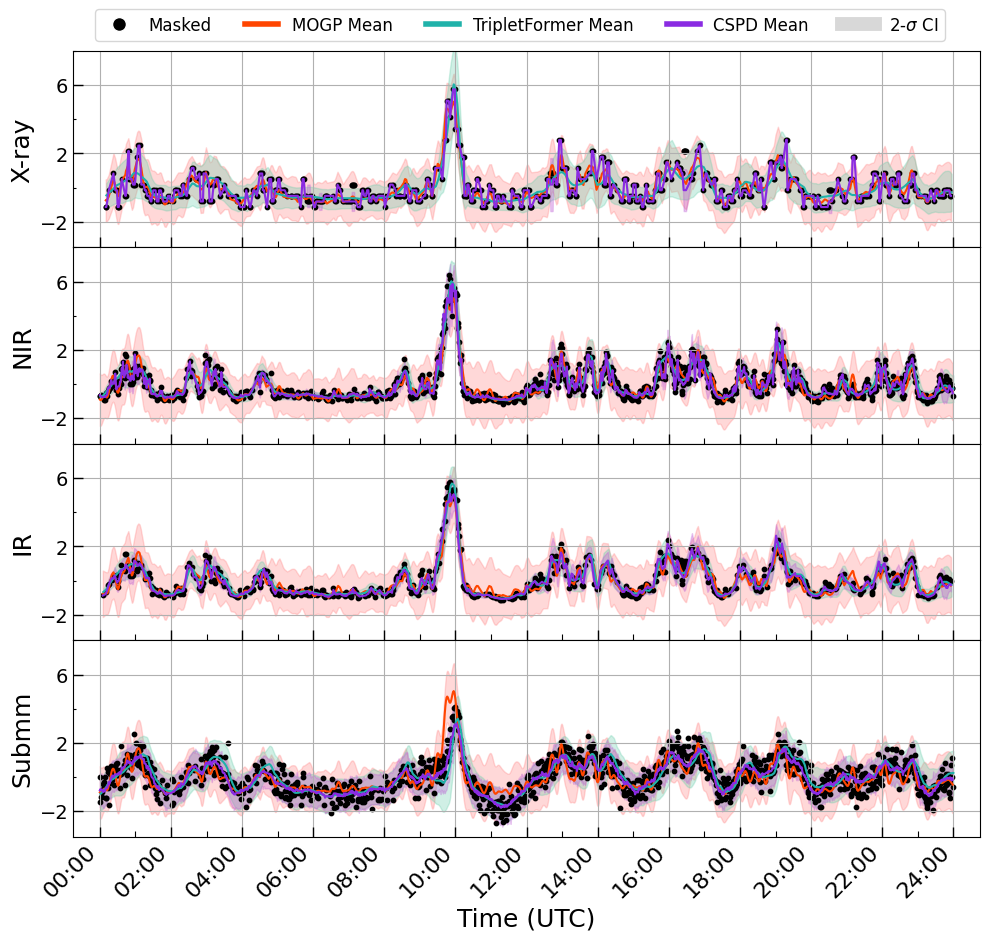

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import HourLocator


def plot_from_saved_data(keys=["X", 'NIR', "IR", "Sub-mm"],
                         y_labels=["X-ray", 'NIR', "IR", "Submm"],
                         gaussian_file='../GPyTorch/model_results.npz',
                         tripletformer_file='../Tripletformer/tripletformer_results.npz',
                         diffusion_file='../Diffusion/model_results.npz'):

    # Load data
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    fig, axs = plt.subplots(len(keys), 1, figsize=(10, 2.5 * len(keys)), sharex=True, gridspec_kw={'hspace': 0})

    # Define UTC start time
    start_time = datetime.strptime('2019-07-17 00:00:00.0', "%Y-%m-%d %H:%M:%S.%f")


    if len(keys) == 1:
        axs = [axs]

    for i, key in enumerate(keys):
        # Extract data
        gauss_test_x = gaussian_data[f"{key}_test_x"]
        gauss_test_y = gaussian_data[f"{key}_test_y"]
        gauss_pred_means = gaussian_data[f"{key}_predicted_means"]
        gauss_lower = gaussian_data[f"{key}_lower_bound"]
        gauss_upper = gaussian_data[f"{key}_upper_bound"]

        triplet_test_x = tripletformer_data[f"{key}_test_x"]
        triplet_pred_means = tripletformer_data[f"{key}_predicted_means"]
        triplet_lower = tripletformer_data[f"{key}_lower_bound"]
        triplet_upper = tripletformer_data[f"{key}_upper_bound"]

        diffusion_test_x = diffusion_data[f"{key}_test_x"]
        diffusion_pred_means = diffusion_data[f"{key}_predicted_means"]
        diffusion_lower = diffusion_data[f"{key}_lower_bound"]
        diffusion_upper = diffusion_data[f"{key}_upper_bound"]

        gauss_time = [start_time + timedelta(minutes=int(t)) for t in gauss_test_x]
        triplet_time = [start_time + timedelta(minutes=int(t)) for t in triplet_test_x]
        diffusion_time = [start_time + timedelta(minutes=int(t)) for t in diffusion_test_x]


        ax = axs[i]

        # Plot test points
        ax.plot(gauss_time, gauss_pred_means, color='#FF4500', linewidth=1.5)
        ax.fill_between(gauss_time, gauss_lower, gauss_upper, alpha=0.3, color='#FF7F7F')

        ax.plot(triplet_time, triplet_pred_means, color='#20B2AA', linewidth=1.5)
        ax.fill_between(triplet_time, triplet_lower, triplet_upper, alpha=0.3, color='#66CDAA')

        ax.plot(diffusion_time, diffusion_pred_means, color='#8A2BE2', linewidth=1.5)
        ax.fill_between(diffusion_time, diffusion_lower, diffusion_upper, alpha=0.3, color='#BA55D3')

        ax.scatter(gauss_time, gauss_test_y, s=10, color='black', label='Masked', alpha=1)


        # Style
        ax.set_ylabel(y_labels[i], fontsize=18,) #fontweight='bold')
        ax.set_ylim(-3.5, 8.0)
        ax.set_yticks([-2.0, 2.0, 6.0])  # major ticks

        # Manually place a single minor tick halfway between each major y-tick
        ax.yaxis.set_minor_locator(MultipleLocator(2.0))  # Halfway between 2.0-spaced ticks
        ax.tick_params(axis='y', which='minor', length=2, width=0.8, labelsize=0, grid_alpha=0, direction='in')

        ax.tick_params(axis='both', labelsize=14, length=7, width=1, direction='in')  # major ticks
        # ax.tick_params(axis='y', which='minor', length=4, width=0.8, labelsize=0, grid_alpha=0)  # minor ticks

        ax.grid(True)
        ax.label_outer()

    # axs[-1].set_xlabel("Timesteps", fontsize=14, fontweight='bold')

    # Define 2-hour tick marks from start to 24h
    xticks_2hr = [start_time + timedelta(minutes=120 * i) for i in range(13)]
    xtick_labels = [t.strftime('%H:%M') if i < 12 else '24:00' for i, t in enumerate(xticks_2hr)]

    axs[-1].set_xticks(xticks_2hr)
    axs[-1].set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=16)
    axs[-1].set_xlabel("Time (UTC)", fontsize=18, )#fontweight='bold')

    # Set custom x-axis limits: from 23:15 the day before to 00:45 the next day
    xlim_start = datetime.strptime('2019-07-16 23:15:00.0', "%Y-%m-%d %H:%M:%S.%f")
    xlim_end   = datetime.strptime('2019-07-18 00:45:00.0', "%Y-%m-%d %H:%M:%S.%f")

    for ax in axs:
        ax.set_xlim([xlim_start, xlim_end])


    # Add minor ticks every 1 hour on x-axis
    for ax in axs:
        ax.xaxis.set_minor_locator(HourLocator(interval=1))  # every hour
        ax.tick_params(axis='x', which='minor', length=4, width=0.8, labelsize=0, grid_alpha=0, direction='in')

    # Legend with styled markers and font
    legend_handles = [
        Line2D([0], [0], marker='o', color='w', label='Masked', markerfacecolor='black', markersize=10),
        Line2D([0], [0], color='#FF4500', label='MOGP Mean', linewidth=4),
        Line2D([0], [0], color='#20B2AA', label='TripletFormer Mean', linewidth=4),
        Line2D([0], [0], color='#8A2BE2', label='CSPD Mean', linewidth=4),
        Line2D([0], [0], color='gray', linewidth=10, alpha=0.3, label=r'2-$\sigma$ CI')  # CI visual patch
    ]
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.525, 0.975), ncol=5, fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.savefig('simulated_comparison.pdf', format='pdf', bbox_inches='tight')
    plt.show()


# Example usage:
plot_from_saved_data()